In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import tensorflow as tf
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
def load_model(device):
    theme_classifier = pipeline("zero-shot-classification",
                                model = model_name,
                                device = device)
    
    return theme_classifier

In [6]:
theme_classifier = load_model(device)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [8]:
 theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [9]:
theme_classifier (
    "I love you, do you love me?",
    theme_list,
    multi_label=True
)

{'sequence': 'I love you, do you love me?',
 'labels': ['love',
  'dialogue',
  'friendship',
  'hope',
  'self development',
  'sacrifice',
  'battle',
  'betrayal'],
 'scores': [0.9736130237579346,
  0.9711853861808777,
  0.8081257939338684,
  0.7793127298355103,
  0.3636735677719116,
  0.2898041307926178,
  0.05366253852844238,
  0.020993078127503395]}

In [10]:
# load dataset
files = glob("/kaggle/input/subtitles/*.ass")

print(len(files))

files.sort()

print(files[0])
print(files[-1])

218
/kaggle/input/subtitles/Naruto Season 1 - 01.ass
/kaggle/input/subtitles/Naruto Season 9 - 220.ass


In [11]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]           # why removed from 0-26 lines? because those lines contains meta data, which we don't need

    new_lines = []  # Create an empty list to store modified lines

    for line in lines:  # Loop through each line in the 'lines' list
        parts = line.split(",")  # Split the line into a list using ',' as the separator
        selected_parts = parts[9:]  # Keep only the elements from index 9 onward
        new_line = ",".join(selected_parts)  # Join the selected parts back into a string
        new_lines.append(new_line)  # Add the modified line to the new list

    lines = new_lines

In [12]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [13]:
lines = [line.replace('\\N', ' ') for line in lines]

In [14]:
# check first two sentences
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [15]:
# join first 10 sentences with separated by space
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [ ]:
print(lines)

In [16]:
# extract episode number
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [17]:
def load_subtitles_dataset(dataset_path):
    # load dataset
    subtitles_path = glob(dataset_path+'/*.ass')
    subtitles_path.sort()

    scripts = []
    episode_num = []

    for path in subtitles_path:

        #read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]           # why removed from 0-26 lines? because those lines contains meta data, which we don't need

            new_lines = []  # Create an empty list to store modified lines

            for line in lines:  # Loop through each line in the 'lines' list
                parts = line.split(",")  # Split the line into a list using ',' as the separator
                selected_parts = parts[9:]  # Keep only the elements from index 9 onward
                new_line = ",".join(selected_parts)  # Join the selected parts back into a string
                new_lines.append(new_line)  # Add the modified line to the new list

            lines = new_lines
        
        # cleaning process
        lines = [line.replace('\\N', ' ') for line in lines]

        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode" : episode_num, "script" : scripts})

    return df

In [18]:
dataset_path = "/kaggle/input/subtitles"

df = load_subtitles_dataset(dataset_path)

In [19]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


### Run Model

In [20]:
script = df.iloc[0]['script']   # 1st row, script column

print(script)

A long time ago, a powerful demon fox appeared with nine tails.
 With its powerful tails,
 it could smash mountains and create tidal waves.
 A band of Ninjas rose to defend their village from attack.
 We have to wait until the Fourth Hokage gets here!
 We can't let it get any closer to our village!
 One great Ninja was able to imprison the monster,
 but died in the process.
 This Ninja was known as… the Fourth Hokage.
 Naruto!
 Why did you do such a thing?!
 You're really gonna get it this time!
 I don't care!
 You know your problem?
 You can't do the things I do!
 Only I can do this!
 I'm better than all of you! Believe it!
 There's a problem, sir!
 Lord Hokage!
 What is it?
 Did that Naruto do something again?
 Yes. He climbed onto the Mountainside Images…
 And he vandalized and graffitied all over them!
 Wait!
 Ha ha…
 Why should I?
 Hey, Naruto!
 How did you suddenly get here, lruka Sensei?
 The question is what are you doing here when you should be in class now?
 Now listen, Narut

In [21]:
script_sentences = sent_tokenize(script)
print(script_sentences[:3])

['A long time ago, a powerful demon fox appeared with nine tails.', 'With its powerful tails,\n it could smash mountains and create tidal waves.', 'A band of Ninjas rose to defend their village from attack.']


In [22]:
# batch sentences

sentence_batch_size = 20
script_batches = []

for index in range(0, len(script_sentences), sentence_batch_size):
     
    sent = " ".join(script_sentences[index: index + sentence_batch_size])

    script_batches.append(sent)

In [23]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [24]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [25]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800742268562317,
   0.9396904110908508,
   0.8546884059906006,
   0.7349812388420105,
   0.7284976243972778,
   0.199097722768783

In [26]:
# Wrangle output
# battle: [1st batch, 2nd batch, ....]
# dialogue: [1st batch, 2nd batch, ...]
themes = {}

for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [27]:
themes

{'dialogue': [0.9800742268562317, 0.9370126724243164],
 'betrayal': [0.9396904110908508, 0.6457259654998779],
 'battle': [0.8546884059906006, 0.6581317186355591],
 'sacrifice': [0.7349812388420105, 0.6258842349052429],
 'self development': [0.7284976243972778, 0.8678209185600281],
 'hope': [0.19909772276878357, 0.2042393535375595],
 'friendship': [0.059223175048828125, 0.08603338897228241],
 'love': [0.040261924266815186, 0.02802056074142456]}

In [28]:
themes= {key : np.mean(np.array(value)) for key, value in themes.items()}

In [29]:
themes

{'dialogue': 0.958543449640274,
 'betrayal': 0.7927081882953644,
 'battle': 0.7564100623130798,
 'sacrifice': 0.6804327368736267,
 'self development': 0.798159271478653,
 'hope': 0.20166853815317154,
 'friendship': 0.07262828201055527,
 'love': 0.03414124250411987}

In [30]:
def get_themes_inference(script):
    # sentence tokenize
    script_sentences = sent_tokenize(script)

    # batch sentences
    sentence_batch_size = 20
    script_batches = []

    for index in range(0, len(script_sentences), sentence_batch_size):
     
        sent = " ".join(script_sentences[index: index + sentence_batch_size])
        script_batches.append(sent)

    # run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
        )

    # wrangle output
    themes = {}

    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes= {key : np.mean(np.array(value)) for key, value in themes.items()}

    return themes


In [31]:
df = df.head()

In [32]:
output_themes = df['script'].apply(get_themes_inference)

In [33]:
print(output_themes)

0    {'dialogue': 0.958543449640274, 'betrayal': 0....
1    {'dialogue': 0.9606061279773712, 'sacrifice': ...
2    {'dialogue': 0.9430069327354431, 'sacrifice': ...
3    {'dialogue': 0.7951259016990662, 'sacrifice': ...
4    {'dialogue': 0.9142751693725586, 'betrayal': 0...
Name: script, dtype: object


In [34]:
theme_df = pd.DataFrame(output_themes.tolist())

In [35]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [36]:
df[theme_df.columns] = theme_df

In [37]:
df.head()

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684846,0.570703,0.482811,0.154534,0.046261,0.173261
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",0.943007,0.339493,0.707887,0.661518,0.724143,0.573633,0.342221,0.394864
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",0.795126,0.554724,0.723674,0.652153,0.861328,0.445292,0.525343,0.315333
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",0.914275,0.891103,0.783643,0.585848,0.550458,0.093764,0.073856,0.054071


### Visualize Output

In [42]:
df.drop('dialogue', axis=1) #remove dialogue column

,episode,script,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.429944,0.684846,0.570703,0.482811,0.154534,0.046261,0.173261
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",0.339493,0.707887,0.661518,0.724143,0.573633,0.342221,0.394864
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",0.554724,0.723674,0.652153,0.861328,0.445292,0.525343,0.315333
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",0.891103,0.783643,0.585848,0.550458,0.093764,0.073856,0.054071


In [43]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']

theme_output

,theme,score
0,dialogue,4.571558
1,betrayal,3.007972
2,battle,3.656460
3,sacrifice,3.150654
4,self development,3.416899
5,hope,1.468891
6,friendship,1.060309
7,love,0.971670


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


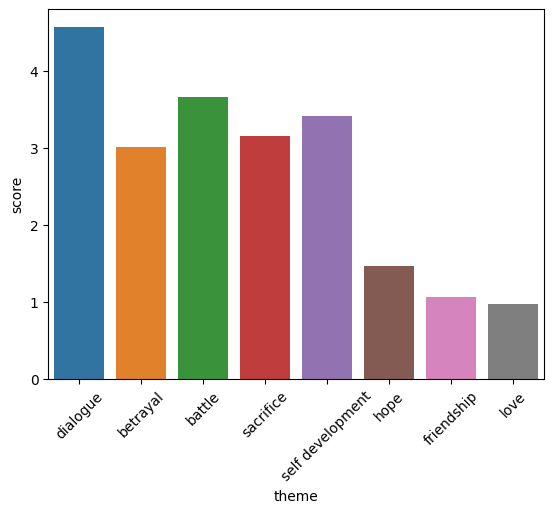

In [46]:
sns.barplot(data = theme_output, x ="theme", y="score")
plt.xticks(rotation=45)
plt.show()